In [1]:
%pylab inline
import json
import pandas as pd
import seaborn as sns

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
results_file = "../results/experiment_ER.json"

results = []
for results_file in ["../results/experiment_ER.json", "../results/experiment_ER_2.json"]:
    results.append(pd.read_json(results_file, orient='records', lines=True))
results = pd.concat(results).reset_index(drop=True)
results.head()

,network_params,init_opinions_params,init_confidence_params,init_alpha_experts_params,tau,N,frac_experts,n_simul,seed,converged,total_steps,time_elapsed,rmsd_truth_a,rmsd_truth_e,rmsd_truth_all,t_gen_net,time_updates
0,ER_10,uniform,const_0.1,const_0.1,0.75,1000,0.05,9,2001,False,301,6.926883,0.361206,0.404281,0.363481,0.030628,6.882095
1,ER_10,uniform,const_0.1,const_0.1,0.75,1000,0.05,1,1993,False,301,6.971622,0.333885,0.326826,0.333536,0.036161,6.921264
2,ER_10,uniform,const_0.1,const_0.1,0.75,1000,0.05,3,1995,False,301,6.989624,0.349236,0.429803,0.353700,0.027624,6.947603
3,ER_10,uniform,const_0.1,const_0.1,0.75,1000,0.05,2,1994,False,301,7.008707,0.361247,0.335284,0.359993,0.037179,6.957206
4,ER_10,uniform,const_0.1,const_0.1,0.75,1000,0.05,7,1999,False,301,7.040947,0.343427,0.393836,0.346122,0.032854,6.993201


In [3]:
res = []
for group, rows in results.groupby(list(results.columns[:7])):
    
    k_mean = int(group[0].split("_")[1])
    confid = float(group[2].split("_")[1])
    alpha = float(group[3].split("_")[1])
    tau = float(group[4])
    N = int(group[5])
    frac_exp = float(group[6])
    
    rmds_final_mean = rows.rmsd_truth_all.mean()
    rmds_final_std = rows.rmsd_truth_all.std()
    steps_end_mean = rows.total_steps.mean()
    steps_end_std = rows.total_steps.std()
    
    res.append([k_mean, confid, alpha, tau, N, frac_exp, rmds_final_mean, rmds_final_std,
               steps_end_mean, steps_end_std])
    
    
res = pd.DataFrame(res, columns=['k_mean', 'confid', 'alpha', 'tau', 'N', 'frac_exp', 
                                 'rmds_final_mean', 'rmds_final_std',
                                'steps_end_mean', 'steps_end_std'])
res.head()

,k_mean,confid,alpha,tau,N,frac_exp,rmds_final_mean,rmds_final_std,steps_end_mean,steps_end_std
0,10,0.1,0.1,0.75,1000,0.05,0.360466,0.031326,300.69,3.100000
1,10,0.1,0.1,0.75,1000,0.10,0.359121,0.024578,293.66,28.485765
2,10,0.1,0.1,0.75,1000,0.20,0.366034,0.013076,289.42,46.441270
3,10,0.1,0.1,0.90,1000,0.05,0.477933,0.032779,301.00,0.000000
4,10,0.1,0.1,0.90,1000,0.10,0.481903,0.025977,295.12,22.206687


In [4]:
res.tau.nunique(), res.frac_exp.nunique()

(3, 3)

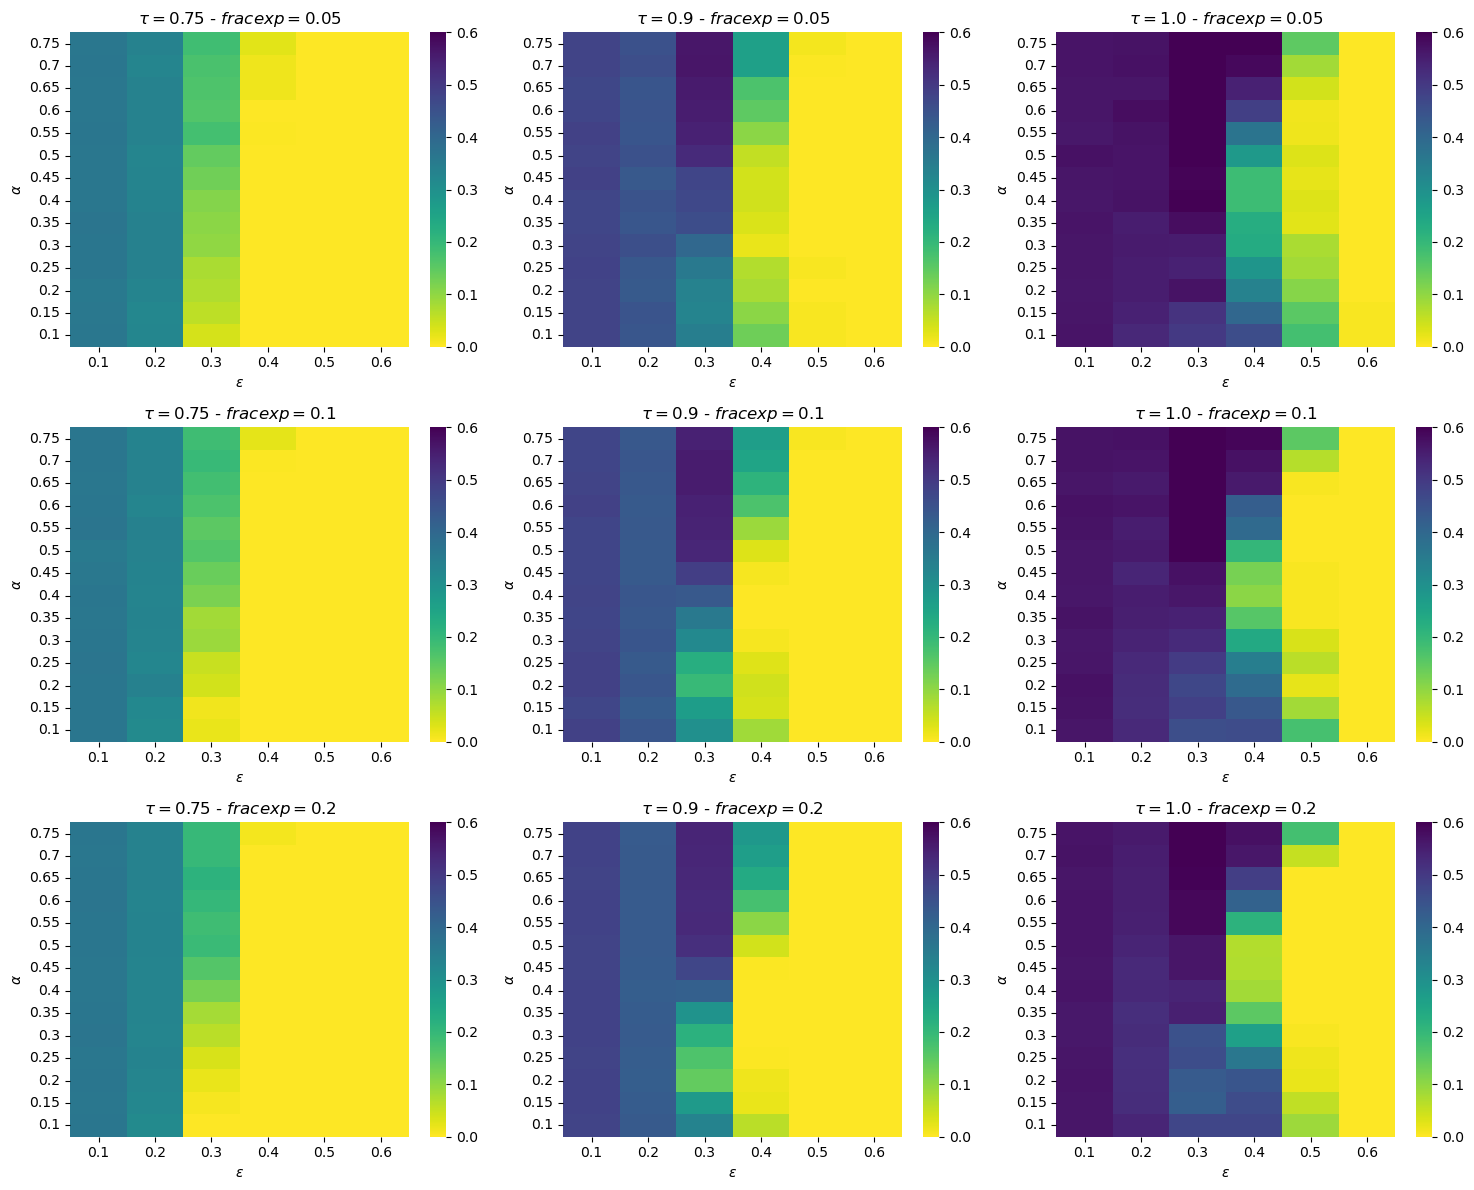

In [6]:
plt.figure(figsize=(15,12))
n_plot = 1
for group, rows in res[(res.k_mean == 20)].sort_values(['tau', 'frac_exp']).groupby(['frac_exp', 'tau']):
    
    rows = rows[['confid', 'alpha', 'rmds_final_mean', 'rmds_final_std']]
    vals_alpha = rows.alpha.sort_values().unique().tolist()
    vals_confid = rows.confid.sort_values().unique().tolist()
    
    #rows.loc[:, 'x'] = rows.confid.apply(lambda i: vals.index(i))
    #rows.loc[:, 'y'] = rows.alpha.apply(lambda i: vals.index(i))
    
    mat = np.empty((len(vals_alpha), len(vals_confid)))
    for _, row in rows.iterrows():
        mat[int(vals_alpha.index(row.alpha)), int(vals_confid.index(row.confid))] = row.rmds_final_mean
        
    #mat = mat[::-1, :]
    mat = pd.DataFrame(mat)
    mat.columns = vals_confid
    mat.index = vals_alpha
    mat = mat[::-1]
    
    plt.subplot(3, 3, n_plot)
    #ax = plt.matshow(mat, fignum=0, vmin=0, vmax=0.6)
    ax = sns.heatmap(data=mat, vmin=0, vmax=0.6, cmap='viridis_r')

    #plt.colorbar()

    plt.title(fr"$\tau={group[1]}$ - $frac exp={group[0]}$")
    plt.xlabel(r"$\epsilon$")
    plt.ylabel(r"$\alpha$")
    #plt.xticks(range(len(vals_confid)), vals_confid);
    #plt.yticks(range(len(vals_alpha)), vals_alpha[::-1], rotation=0);
    #plt.gca().xaxis.tick_bottom()
    
    #plt.colorbar()
    
    n_plot += 1
    
plt.tight_layout()

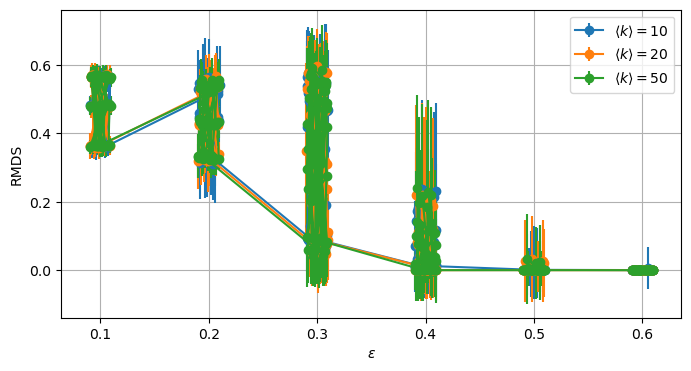

In [6]:
plt.figure(figsize=(8,4))
for k_mean, rows in res.groupby('k_mean'):
    
    rows = rows.sort_values('confid')
    
    dx = np.random.random(rows.shape[0]) * 0.02 - 0.01
    plt.errorbar(rows.confid + dx, rows.rmds_final_mean, rows.rmds_final_std, fmt='o-', 
                 label=fr"$\left< k \right>={k_mean}$")
    
plt.legend()
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"RMDS")
plt.grid()

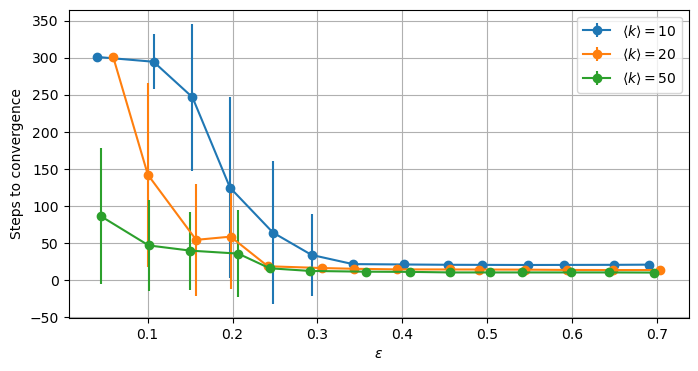

In [7]:
plt.figure(figsize=(8,4))
for k_mean, rows in res.groupby('k_mean'):
    
    rows = rows.sort_values('confid')
    
    dx = np.random.random(rows.shape[0]) * 0.02 - 0.01
    plt.errorbar(rows.confid + dx, rows.steps_end_mean, rows.steps_end_std, fmt='o-', 
                 label=fr"$\left< k \right>={k_mean}$")
    
plt.legend()
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"Steps to convergence")
plt.grid()